In [192]:
import argparse
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import os
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import numpy as np
import librosa
from tqdm import tqdm
import numpy as np
import os
from data_proc import get_labels

#DATA_PATH = 'C:\\Users\\silly\\Documents\\voice_pathology\\npy\\'
#p = 'C:\\Users\\silly\\Documents\\voice_pathology\\SVD_db\\i'



In [339]:
path = 'C:\\Users\\silly\\Documents\\voice_pathology\\npy_u\\'

def get_train_test(train = 0.9, random_state = 13):
    # get available class labels
    labels, indices, _ = get_labels()

    # Getting first arrays
    X = np.load(path + labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(path + label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value=(i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= 1 - train, random_state = random_state, shuffle=False)


train_x, test_x, train_y, test_y = get_train_test()

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

train_y_categorical = to_categorical(train_y)
test_y_categorical = to_categorical(test_y)

print(train_y_categorical.shape)
print(test_y_categorical.shape)

(1567, 20, 50)
(175, 20, 50)
(1567,)
(175,)
(1567, 1567)
(175, 1742)


In [340]:
# add depth dimension for cnn
x, y, z = train_x.shape
train_x = train_x.reshape(x, y, z,1)
test_x = test_x.reshape(test_x.shape[0], y, z,1)

#train_y_categorical = np.delete(train_y_categorical,1741,axis=1)
#train_y_categorical = np.delete(train_y_categorical,1740,axis=1)
#train_y_categorical = train_y_categorical.reshape(train_y_categorical.shape[0], y, z, 1)
#test_y_categorical = test_x.reshape(test_y_categorical.shape[0], y, z, 1)

train_y_categorical = np.delete(train_y_categorical,np.s_[2:],axis=1)
test_y_categorical = np.delete(test_y_categorical,np.s_[2:],axis=1)


print(train_x.shape)
print(test_x.shape)
print(train_y_categorical.shape)
print(test_y_categorical.shape)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(y, z, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

model.summary()

(1567, 20, 50, 1)
(175, 20, 50, 1)
(1567, 2)
(175, 2)
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 18, 48, 32)        320       
_________________________________________________________________
batch_normalization_106 (Bat (None, 18, 48, 32)        128       
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 6, 16, 32)         0         
_________________________________________________________________
dropout_168 (Dropout)        (None, 6, 16, 32)         0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 4, 14, 32)         9248      
_________________________________________________________________
batch_normalization_107 (Bat (None, 4, 14, 32)         128       
_________________________________________________________________

In [78]:
# train the model
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(0.001),
                  metrics=['categorical_accuracy'])
history = model.fit(train_x, train_y_categorical, batch_size=32, epochs=15,
                        callbacks=[keras.callbacks.TensorBoard(log_dir='logs\\adam_2', histogram_freq=0, batch_size=32, 
                                                               write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)],
                        validation_data=(test_x, test_y_categorical))

Epoch 1/15
49/49 [==============================] - 2s 34ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.4639 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/15
49/49 [==============================] - 1s 21ms/step - loss: 37.9185 - categorical_accuracy: 0.5482 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 3/15
49/49 [==============================] - 1s 21ms/step - loss: 60.9445 - categorical_accuracy: 0.6158 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 4/15
49/49 [==============================] - 1s 22ms/step - loss: 153.5501 - categorical_accuracy: 0.6337 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 5/15
49/49 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.6286 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 6/15
49/49 [==============================] - 1s 21ms/step - loss: 1056.7147 - categorical_accuracy: 0.6356 - val_loss: 0.0000e+00 - 

In [342]:
# train the model
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate = 0.000001),
                  metrics=['accuracy'])
history = model.fit(train_x, train_y_categorical, batch_size=2, epochs=10,
                        callbacks=[keras.callbacks.TensorBoard(log_dir='logs\\28', histogram_freq=0, batch_size=32, 
                                                               write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)],
                        validation_data=(test_x, test_y_categorical), validation_split = 0.1)

Epoch 1/10
705/705 [==============================] - 18s 24ms/step - loss: 0.0671 - accuracy: 0.4411 - val_loss: 0.0641 - val_accuracy: 0.7389
Epoch 2/10
705/705 [==============================] - 18s 25ms/step - loss: 0.0658 - accuracy: 0.4362 - val_loss: 0.0641 - val_accuracy: 0.7580
Epoch 3/10
705/705 [==============================] - 16s 23ms/step - loss: 0.0650 - accuracy: 0.4645 - val_loss: 0.0641 - val_accuracy: 0.7707
Epoch 4/10
705/705 [==============================] - 18s 25ms/step - loss: 0.0642 - accuracy: 0.4738 - val_loss: 0.0641 - val_accuracy: 0.7452
Epoch 5/10
705/705 [==============================] - 19s 27ms/step - loss: 0.0642 - accuracy: 0.4277 - val_loss: 0.0641 - val_accuracy: 0.7707
Epoch 6/10
705/705 [==============================] - 17s 25ms/step - loss: 0.0672 - accuracy: 0.4809 - val_loss: 0.0642 - val_accuracy: 0.7707
Epoch 7/10
705/705 [==============================] - 19s 27ms/step - loss: 0.0664 - accuracy: 0.4858 - val_loss: 0.0642 - val_accuracy:

In [343]:
test_loss, test_acc = model.evaluate(test_x, test_y_categorical)

6/6 [==============================] - 0s 8ms/step - loss: 0.0643 - accuracy: 0.8343


In [368]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers

model5 = Sequential()
model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(y, z, 1)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(3, 3)))
model5.add(Dropout(0.25))

model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())

model5.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model5.add(Dropout(0.25))
model5.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
# train the model
model5.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate = 0.000001),
                  metrics=['accuracy'])
history5 = model5.fit(train_x, train_y_categorical, batch_size=2, epochs=10,
                        callbacks=[keras.callbacks.TensorBoard(log_dir='logs\\28', histogram_freq=0, batch_size=32, 
                                                               write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)],
                        validation_data=(test_x, test_y_categorical), validation_split = 0.1)

Epoch 1/100
705/705 [==============================] - 25s 33ms/step - loss: 0.0659 - accuracy: 0.7028 - val_loss: 0.0646 - val_accuracy: 0.6497
Epoch 2/100
705/705 [==============================] - 23s 33ms/step - loss: 0.0694 - accuracy: 0.7007 - val_loss: 0.0646 - val_accuracy: 0.6815
Epoch 3/100
705/705 [==============================] - 18s 26ms/step - loss: 0.0655 - accuracy: 0.6794 - val_loss: 0.0646 - val_accuracy: 0.6879
Epoch 4/100
705/705 [==============================] - 27s 38ms/step - loss: 0.0647 - accuracy: 0.6972 - val_loss: 0.0646 - val_accuracy: 0.6752
Epoch 5/100
705/705 [==============================] - 24s 34ms/step - loss: 0.0670 - accuracy: 0.7199 - val_loss: 0.0646 - val_accuracy: 0.6815
Epoch 6/100
705/705 [==============================] - 25s 36ms/step - loss: 0.0663 - accuracy: 0.7099 - val_loss: 0.0646 - val_accuracy: 0.7006
Epoch 7/100
705/705 [==============================] - 20s 29ms/step - loss: 0.0662 - accuracy: 0.7220 - val_loss: 0.0646 - val_ac

In [369]:
test_loss, test_acc = model5.evaluate(test_x, test_y_categorical)

6/6 [==============================] - 0s 8ms/step - loss: 0.0729 - accuracy: 0.9657


In [292]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(y, z, 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dropout(0.25))
model2.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

model2.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 18, 48, 32)        320       
_________________________________________________________________
batch_normalization_105 (Bat (None, 18, 48, 32)        128       
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 6, 16, 32)         0         
_________________________________________________________________
dropout_166 (Dropout)        (None, 6, 16, 32)         0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                98336     
_________________________________________________________________
dropout_167 (Dropout)        (None, 32)              

In [293]:
# train the model
model2.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
                  metrics=['accuracy'])
history = model2.fit(train_x, train_y_categorical, batch_size=2, epochs=20,
                        callbacks=[keras.callbacks.TensorBoard(log_dir='logs\\27', histogram_freq=0, batch_size=32, 
                                                               write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)],
                        validation_data=(test_x, test_y_categorical), validation_split = 0.1)

Epoch 1/20
705/705 [==============================] - 18s 24ms/step - loss: 0.0683 - accuracy: 0.6191 - val_loss: 0.0681 - val_accuracy: 0.3758
Epoch 2/20
705/705 [==============================] - 17s 25ms/step - loss: 0.0766 - accuracy: 0.5433 - val_loss: 0.0696 - val_accuracy: 0.3439
Epoch 3/20
705/705 [==============================] - 14s 20ms/step - loss: 0.0798 - accuracy: 0.5234 - val_loss: 0.0723 - val_accuracy: 0.9108
Epoch 4/20
705/705 [==============================] - 17s 24ms/step - loss: 0.0742 - accuracy: 0.5511 - val_loss: 0.0763 - val_accuracy: 0.1529
Epoch 5/20
705/705 [==============================] - 18s 25ms/step - loss: 0.0825 - accuracy: 0.5064 - val_loss: 0.0816 - val_accuracy: 0.3949
Epoch 6/20
705/705 [==============================] - 14s 20ms/step - loss: 0.1311 - accuracy: 0.5213 - val_loss: 0.0883 - val_accuracy: 0.3185
Epoch 7/20
705/705 [==============================] - 13s 19ms/step - loss: 0.1217 - accuracy: 0.5014 - val_loss: 0.0963 - val_accuracy:

# Model Evaluation

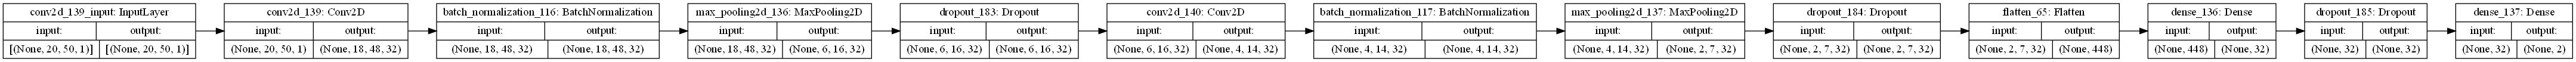

In [401]:
from keras.utils.vis_utils import plot_model
plot_model(model5, to_file='cnn_model_plot_last_h.png',rankdir='LR', show_shapes=True, show_layer_names=True)

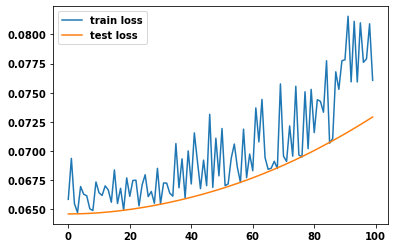

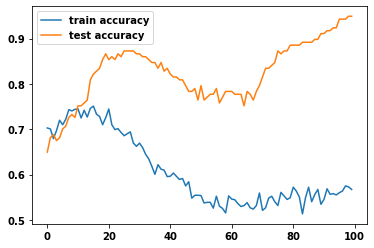

In [371]:
from matplotlib import pyplot as plt
# plot history
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.plot(history5.history['accuracy'], label='train accuracy')
plt.plot(history5.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

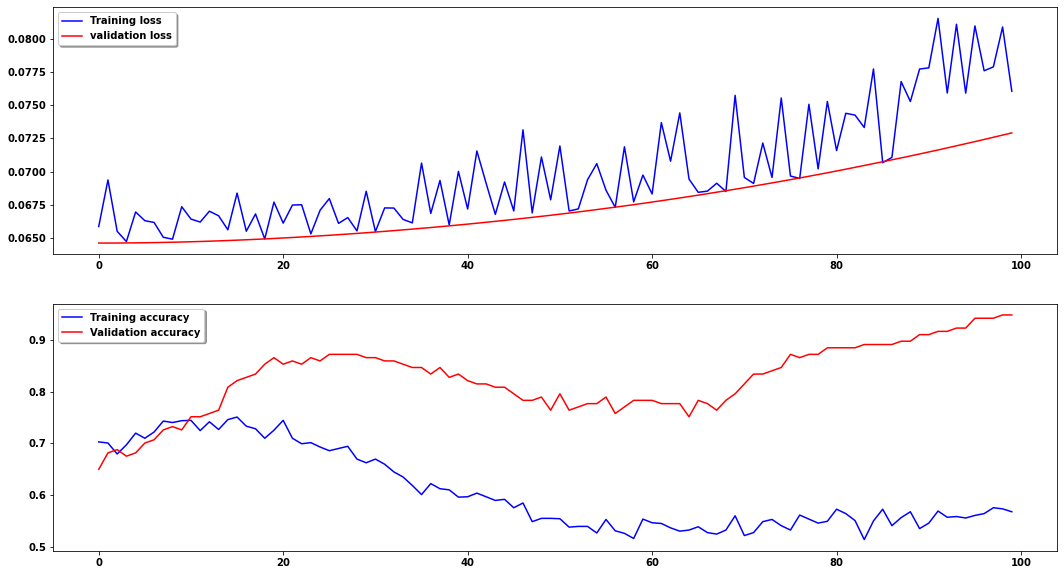

In [372]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history5.history['loss'], color='b', label="Training loss")
ax[0].plot(history5.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history5.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history5.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [424]:
import pandas as pd
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Pathological', 'Healthy']

conf = pd.DataFrame(mat, columns=['True Pathology','True Healthy'], index=['pred:Pathological','pred:Healthy'])
conf


,True Pathology,True Healthy
pred:Pathological,169,6
pred:Healthy,0,0


In [ ]:
from sklearn.metrics import classification_report
actual = np.argmax(test_y_categorical, axis =1)
predicted = np.argmax(model.predict(test_x), axis=1)
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Outcome values : 
 0 0 29 146
Classification report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           0       1.00      0.83      0.91       175

    accuracy                           0.83       175
   macro avg       0.50      0.42      0.45       175
weighted avg       1.00      0.83      0.91       175



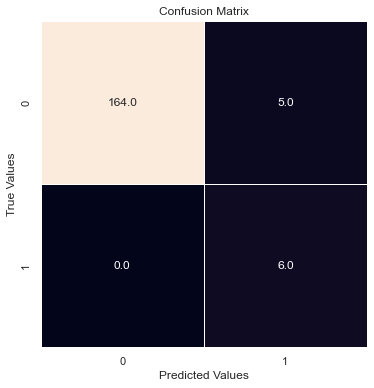

In [460]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(6, 6)) # Set Figure
predicted = np.argmax(model5.predict(test_x), axis=1)

mat = confusion_matrix(actual,predicted)
# Plot Confusion matrix
sns.set_theme()
sns.heatmap(mat.T, square=True, annot=True, cbar=False, fmt=".1f" , linewidths=.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show();

In [463]:
from sklearn.metrics import classification_report
#actual = np.argmax(test_y_categorical, axis =1)
predicted = np.argmax(model5.predict(test_x), axis=1)
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Outcome values : 
 6 5 0 164
Classification report : 
               precision    recall  f1-score   support

           1       1.00      0.55      0.71        11
           0       0.97      1.00      0.98       164

    accuracy                           0.97       175
   macro avg       0.99      0.77      0.85       175
weighted avg       0.97      0.97      0.97       175



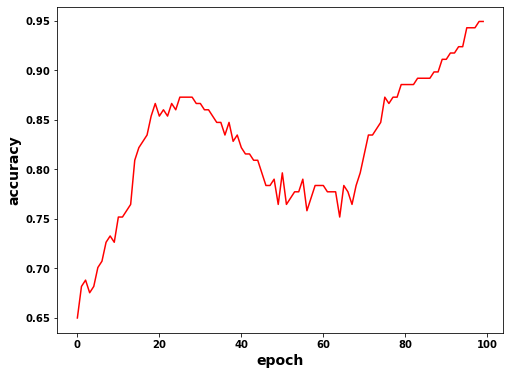

In [416]:
f = plt.figure(figsize=(8,6))
plt.plot(history5.history["val_accuracy"], color = 'red')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
f.savefig('accuracy.pdf', bbox_inches='tight')

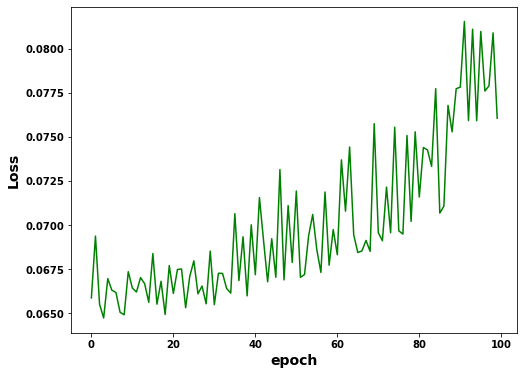

In [415]:
f = plt.figure(figsize=(8,6))
plt.plot(history5.history["loss"], color =  'green')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
f.savefig('loss.pdf', bbox_inches='tight')

In [100]:
test_path = 'C:\\Users\\silly\\Documents\\voice_pathology\\model_testing\\'
print('Please add file to predict:')
print('==========================')
get_labels(test_path)[0]
save_data_to_array(test_path)
X = np.load(test_path + get_labels(test_path)[0][0] + '.npy')
print('==========================')
print('Sample shape: ', X.shape)
print('Reshape to 4D:')
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
print(X.shape)
print('Predicting sample...')
prediction = model.predict(X)
print('==========================')
pred = np.argmax(prediction, axis = 1)
if pred == 1:
    print('Sample is healthy voice')
else:
    print('Sample is pathological voice')


Please add file to predict:


Saving vectors of label - 'pathological.wav': 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 90.87it/s]

saved data :  pathological.wav
Sample shape:  (1, 20, 50)
Reshape to 4D:
(1, 20, 50, 1)
Predicting sample...


Sample is pathological voice
